In [30]:
import cellstates as cs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Model inputs:**
* UMI data
* a prior (pseudo-counts for every gene)
* a partition of cells into clusters

**Model output:**
* a log-likelihood for each cluster



In [2]:
datafile = './test_data/simulated_data.npy'
data = np.load(datafile)
G, N = data.shape
G, N

(19052, 2298)

In [3]:
data.sum(axis=0).mean()

4531.766318537859

In [4]:
# define pseudo-counts with prior parameter alpha
alpha = 4096.0
lmbd = alpha*data.sum(axis=1)/data.sum()

#filter out non-expressed genes
mask=lmbd>0
data = data[mask, :]
lmbd = lmbd[mask]

clusters = np.arange(N)

**The Cluster class:**

* programmed in cython:
    * syntax very similar to python, but code is translated into C and compiled for fast executions
    * multiple threads possible
    * classes and functions can be imported into Python after compilation

* Inputs of Cluster class object:
    * Data table of ints
    * prior parameter array
    * Clusters
    * Number of threads (optional)
    * Max number of clusters (default=n_cells)
    * Number of cached lngamma values per gene (default=100)
* Properties of Cluster class object:
    * N_clusters
    * Cluster likelihoods and Total_likelihood
    * Cluster sizes
* Methods for class include 
    * running MCMC
    * Optimize clusters (merging of clusters, non-random optimal moves)
    * Move cells or merge clusters explicitly
    * Get posterior gene expression states (mean&variance or mode)
    * Get cluster hierarchy


In [10]:
clst = cs.Cluster(data, lmbd, clusters, 
                  num_threads=8, n_cache=1000)

In [11]:
clst.total_likelihood

-83483186.21598366

In [12]:
clst.cluster_sizes

array([1, 1, 1, ..., 1, 1, 1])

An Markov-chain Monte Carlo algorithm is used to optimize likelihood as a function of the partition

In [13]:
clst.biased_monte_carlo_sampling(N_steps=1000, tries_per_step=100)

RuntimeError: Only 898 moves found within loop limit.Consider raising tries_per_step

In [14]:
clst.total_likelihood

-83349647.4870477

For the full optimization run, the sampling is repeatedly called. At the end, there are also deterministic optimization steps (merging clusters, moving cells into their optimal cluster)

In [16]:
cs.run_mcmc(clst, N_steps=100)

2020-04-01 02:11:24,474 - INFO:initially check output every 100 steps
2020-04-01 02:11:24,476 - INFO:n_clusters=1771, total likelihood=-83349647.4870477
2020-04-01 02:11:27,400 - INFO:n_clusters=1717, total likelihood=-83327293.04996899
2020-04-01 02:11:30,100 - INFO:n_clusters=1664, total likelihood=-83305042.190242
2020-04-01 02:11:32,956 - INFO:n_clusters=1609, total likelihood=-83279082.23000214
2020-04-01 02:11:35,906 - INFO:n_clusters=1564, total likelihood=-83258230.35886353
2020-04-01 02:11:38,878 - INFO:n_clusters=1509, total likelihood=-83233308.17009947
2020-04-01 02:11:41,920 - INFO:n_clusters=1454, total likelihood=-83204300.04154615
2020-04-01 02:11:44,897 - INFO:n_clusters=1398, total likelihood=-83171203.65460894
2020-04-01 02:11:47,924 - INFO:n_clusters=1349, total likelihood=-83142524.24495818
2020-04-01 02:11:51,252 - INFO:n_clusters=1294, total likelihood=-83107837.12918337
2020-04-01 02:11:55,096 - INFO:n_clusters=1241, total likelihood=-83074509.04653393
2020-04-0

In [17]:
clst.total_likelihood

-81457510.71362096

In [18]:
clst.n_clusters

9

In [21]:
from sklearn.metrics import adjusted_rand_score
sim_clusters = np.loadtxt('./test_data/simulated_clusters.txt', dtype=int)
adjusted_rand_score(sim_clusters, clst.clusters)

0.9811421746094137

In [23]:
sim_clst = cs.Cluster(data, lmbd, sim_clusters)
sim_clst.total_likelihood

-81458341.62652262

In [24]:
sim_clst.n_clusters

10

**Full optimization pipeline:**
* Choose an initial alpha ~ no. of UMIs per cell
* optimize partition
* check what the optimal alpha for this partition would be
* optimize again if necessary etc.

## Other outputs of the model

**Hierarchical merging of clusters**
* in every step we are looking for the two clusters that when merged result in the smallest change in LL

In [25]:
cluster_hierarchy, delta_LL_history = clst.get_cluster_hierarchy()

In [26]:
cluster_hierarchy

[(1, 6), (0, 4), (2, 8), (2, 7), (0, 5), (0, 1), (2, 3), (0, 2)]

In [27]:
delta_LL_history

[-29439.888014692813,
 -31737.11723736301,
 -68090.3993109297,
 -115108.55503090471,
 -125368.8534150999,
 -257236.1339237988,
 -412260.0136397928,
 -1068365.9011107385]

In [28]:
hierarchy_df = cs.get_hierarchy_df(cluster_hierarchy, delta_LL_history)
hierarchy_df

,cluster_new,cluster_old,delta_LL
0,1,6,-2.943989e+04
1,0,4,-3.173712e+04
2,2,8,-6.809040e+04
3,2,7,-1.151086e+05
4,0,5,-1.253689e+05
5,0,1,-2.572361e+05
6,2,3,-4.122600e+05
7,0,2,-1.068366e+06


I have built functions that can transform these trees into **other formats**:
* scipy linkage matrix: 
    * integrated into python
    * only allows one leaf per cluster
    * only positive distances allowed
    
* Newick format
    * widely used for phylogenetic trees
    * allows for one leaf per cell
    * only positive distances allowed in plotting tool I use

(<Figure size 648x432 with 1 Axes>,
 {'icoord': [[5.0, 5.0, 15.0, 15.0],
   [35.0, 35.0, 45.0, 45.0],
   [25.0, 25.0, 40.0, 40.0],
   [10.0, 10.0, 32.5, 32.5],
   [75.0, 75.0, 85.0, 85.0],
   [65.0, 65.0, 80.0, 80.0],
   [55.0, 55.0, 72.5, 72.5],
   [21.25, 21.25, 63.75, 63.75]],
  'dcoord': [[0.0, 29439.888014692813, 29439.888014692813, 0.0],
   [0.0, 31737.11723736301, 31737.11723736301, 0.0],
   [0.0, 125368.8534150999, 125368.8534150999, 31737.11723736301],
   [29439.888014692813,
    257236.1339237988,
    257236.1339237988,
    125368.8534150999],
   [0.0, 68090.3993109297, 68090.3993109297, 0.0],
   [0.0, 115108.55503090471, 115108.55503090471, 68090.3993109297],
   [0.0, 412260.0136397928, 412260.0136397928, 115108.55503090471],
   [257236.1339237988,
    1068365.9011107385,
    1068365.9011107385,
    412260.0136397928]],
  'ivl': ['1', '6', '5', '0', '4', '3', '7', '2', '8'],
  'leaves': [1, 6, 5, 0, 4, 3, 7, 2, 8],
  'color_list': ['#ff0000',
   '#ff0000',
   '#ff0000',
   '

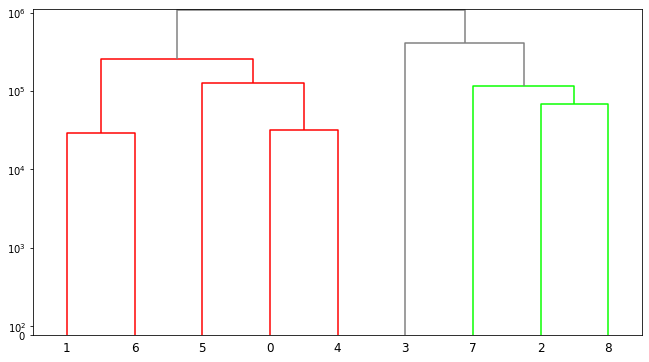

In [41]:
cs.plot_hierarchy_scipy(hierarchy_df, n_groups=3)

In [43]:
import os
os.environ['DISPLAY'] = 'localhost:10.0'

!echo $DISPLAY

localhost:10.0


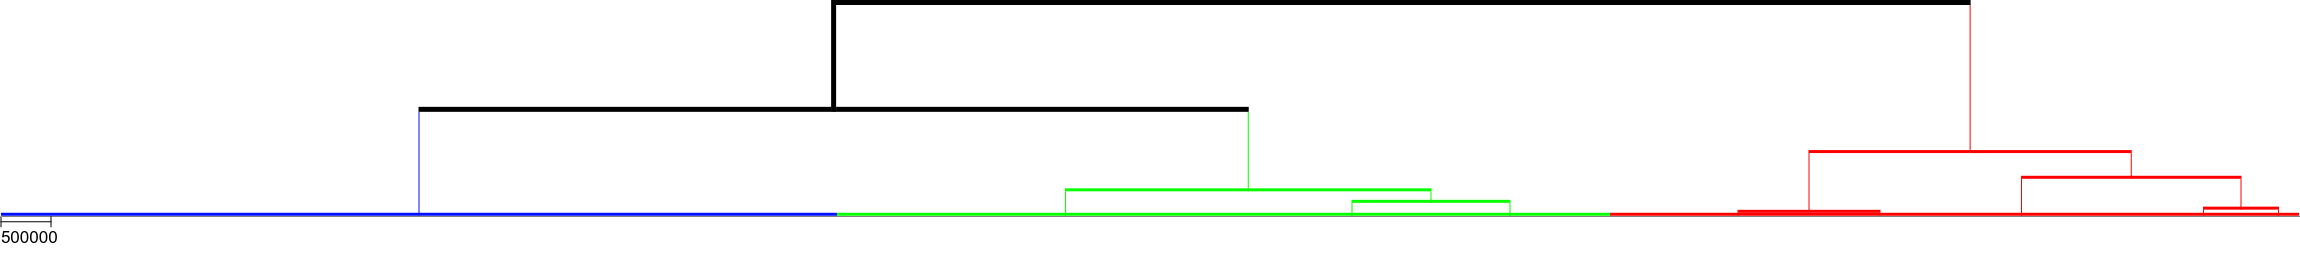

In [48]:
t, ts = cs.plot_hierarchy_ete3(hierarchy_df, clst.clusters, n_groups=3)
t.render('%%inline', tree_style=ts)

In [53]:
score_table = cs.marker_score_table(clst, hierarchy_df)

In [57]:
genes = np.load('./test_data/genes.npy', allow_pickle=True)
genes = genes[mask]

In [59]:
score_df = pd.concat([hierarchy_df, pd.DataFrame(score_table, columns=genes)], axis=1)
score_df


,cluster_new,cluster_old,delta_LL,distance,A1BG_AS1__chr19,A1BG__chr19,A1CF__chr10,A2M_AS1__chr12,A2ML1__chr12,A2M__chr12,...,ZWILCH__chr15,ZWINT__chr10,ZXDA__chrX,ZXDB__chrX,ZXDC__chr3,ZYG11A__chr1,ZYG11B__chr1,ZYX__chr7,ZZEF1__chr17,ZZZ3__chr1
0,1,6,-2.943989e+04,2.944089e+04,0.004138,-0.177228,1.645643,0.017931,-0.115510,0.136550,...,2.506479,-1.670941,-0.227911,0.339247,-1.079766,-0.111372,1.486774,-3.507449,1.849295,1.420626
1,0,4,-3.173712e+04,6.117901e+04,-0.617346,-0.545304,-1.559023,3.082420,-1.287159,-2.869525,...,1.736127,3.106885,1.100123,-3.008204,1.687120,-1.283003,0.918177,2.760153,2.061100,1.434696
2,2,8,-6.809040e+04,1.292704e+05,-0.458745,2.253023,2.224411,4.023539,-1.952977,-0.810837,...,1.897544,2.716450,-0.841652,2.705240,-5.167947,-0.964282,-2.347988,1.047234,2.501816,0.914324
3,2,7,-1.151086e+05,2.443800e+05,-1.180666,2.710218,-3.158431,4.382738,-0.346347,0.196815,...,1.440516,2.453892,1.735502,3.078483,-2.477810,-1.064886,-0.366958,2.291195,2.921868,2.979985
4,0,5,-1.253689e+05,3.697498e+05,0.004342,0.079602,-1.353131,1.979886,-1.917011,-77.841452,...,2.363912,2.496352,2.528471,-6.014227,1.400441,3.918854,1.339301,2.825060,0.868277,1.669073
5,0,1,-2.572361e+05,6.269869e+05,0.003595,0.065916,0.057227,-1.156957,-0.576679,-25.679329,...,2.128315,-1.671320,-1.040704,-0.431304,-0.022093,-0.573084,-1.985347,-6.496781,0.105660,0.531750
6,2,3,-4.122600e+05,1.039248e+06,-1.624208,2.244144,-13.658914,1.294912,-0.634349,0.202475,...,3.160868,3.003813,0.746718,2.206416,1.910812,-0.628214,2.717900,2.251899,-0.427115,-0.578954
7,0,2,-1.068366e+06,2.107615e+06,-0.178672,-0.469975,-6.549753,3.695255,-1.755118,-77.592551,...,2.393602,1.187528,2.019804,-5.247470,-0.670157,-1.750811,-1.177683,-16.398709,2.011458,1.651344


In [60]:
cs.__dir__()

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__path__',
 '__file__',
 '__cached__',
 '__builtins__',
 'cluster',
 'Cluster',
 'run',
 'run_mcmc',
 'helpers',
 'clusters_from_hierarchy',
 'get_hierarchy_df',
 'get_scipy_hierarchy',
 'hierarchy_to_newick',
 'marker_score_table',
 'plotting',
 'plot_hierarchy_scipy',
 'plot_hierarchy_ete3']

## Command line tool

In [61]:
! python run_cellstate.py --help

usage: run_cellstate.py [-h] [-o OUTDIR] [--data DATA] [-d DIRICHLET]
                        [-i INIT] [-t THREADS]

optional arguments:
  -h, --help            show this help message and exit
  -o OUTDIR, --outdir OUTDIR
                        directory for output
  --data DATA           UMI data (path to file)
  -d DIRICHLET, --dirichlet DIRICHLET
                        dirichlet prior parameter
  -i INIT, --init INIT  init clusters (path to file)
  -t THREADS, --threads THREADS
                        number of threads


**outputs currently:**
* optimized_clusters.txt
    * list of cluster labels
* cluster_hierarchy.tsv
    * tsv file of hierarchy_df